# Feature Engineering. Split Dataset

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
upstream = {'init': {'data': 'data/interim/transactions.parquet.gzip'}}
product = None
ROOT = Path(os.path.abspath("")).resolve().parents[0]
DATA = os.path.join(ROOT, "data")
INTERIM_DATA = os.path.join(DATA, "interim")

In [ ]:
trx = pd.read_parquet(
    os.path.join(INTERIM_DATA, "transactions.parquet.gzip")
)

In [4]:
trx.head()

,customer_id,tx_datetime,tx_amount,sector_id,tx_fraud,tx_amount_log,ones,day_of_week,hour,month,is_month_start,is_month_end,is_weekend
0,0,2023-01-07 15:47:39,538.021174,4,0,6.289755,1,5,15,1,0,0,1
1,0,2023-01-07 18:43:44,713.726474,4,1,6.571900,1,5,18,1,0,0,1
2,0,2023-01-10 04:38:48,601.959471,4,0,6.401850,1,1,4,1,0,0,0
3,0,2023-01-10 05:55:56,608.692193,4,0,6.412954,1,1,5,1,0,0,0
4,0,2023-01-10 14:20:06,617.170620,4,0,6.426765,1,1,14,1,0,0,0


In [5]:
train_end = "2023-04-30"
val_end = "2023-05-31"
target_column = "tx_fraud"

X_train = trx[trx["tx_datetime"] <= train_end]
X_val = trx[(trx["tx_datetime"] > train_end) & (trx["tx_datetime"] <= val_end)]
X_test = trx[trx["tx_datetime"] > val_end]

## Verify split

In [6]:
drift_features = [
    "tx_amount",
    "tx_amount_log",
    "is_month_start",
    "is_month_end",
    "is_weekend",
    "hour",
    "month",
]

In [7]:
def summarize_split(name, df, target="tx_fraud"):
    n = len(df)
    pos = int(df[target].sum())
    rate = pos / max(n, 1)
    return dict(split=name, n=n, positives=pos, fraud_rate=rate)


def rolling_rate(df, freq="W", target="tx_fraud"):
    g = df.set_index("tx_datetime").resample(freq)[target]
    return (g.sum() / g.count()).rename("fraud_rate")


def plot_fraud_rate(df, label, freq="W"):
    fr = df.set_index("tx_datetime").resample(freq)["tx_fraud"].mean().rename(label)
    return fr

In [8]:
summary = pd.DataFrame(
    [
        summarize_split("train", X_train),
        summarize_split("val", X_val),
        summarize_split("test", X_test),
    ]
)

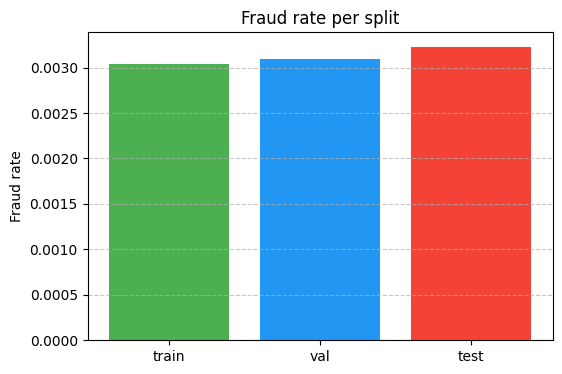

In [9]:
plt.figure(figsize=(6, 4))
plt.bar(
    summary["split"], summary["fraud_rate"], color=["#4caf50", "#2196f3", "#f44336"]
)
plt.title("Fraud rate per split")
plt.ylabel("Fraud rate")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

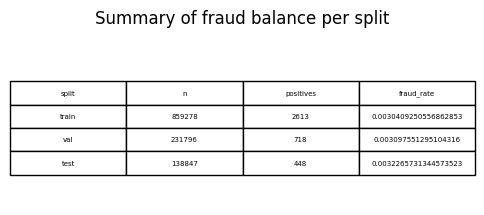

In [10]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")
table = ax.table(
    cellText=summary.values, colLabels=summary.columns, cellLoc="center", loc="center"
)
table.scale(1, 1.4)
plt.title("Summary of fraud balance per split", pad=20)
plt.show()

In [11]:
fra_train = rolling_rate(X_train)
fra_val = rolling_rate(X_val)
fra_test = rolling_rate(X_test)

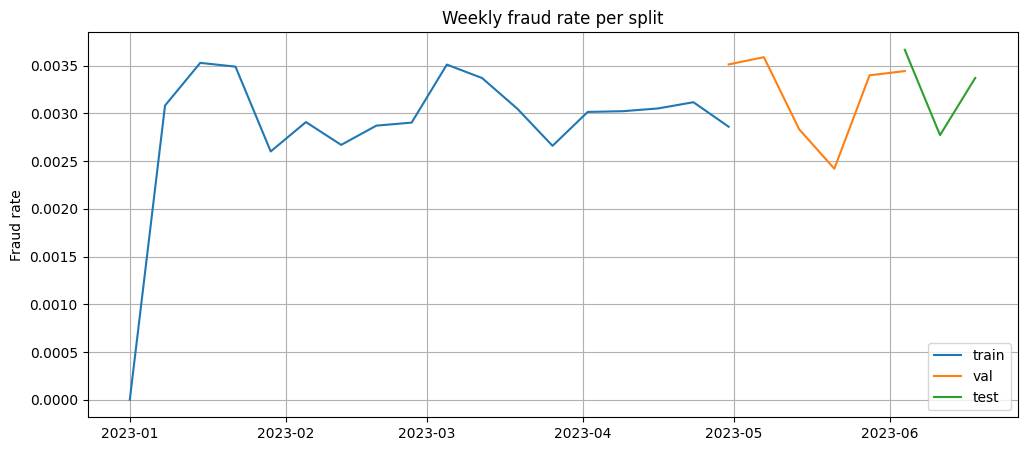

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(fra_train, label="train")
plt.plot(fra_val, label="val")
plt.plot(fra_test, label="test")
plt.title("Weekly fraud rate per split")
plt.ylabel("Fraud rate")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from scipy.stats import ks_2samp

for col in drift_features:
    stat, p = ks_2samp(X_train[col], X_val[col])
    print(f"{col}: KS={stat:.3f}, p={p:.3f}")

tx_amount: KS=0.007, p=0.000
tx_amount_log: KS=0.007, p=0.000
is_month_start: KS=0.006, p=0.000
is_month_end: KS=0.006, p=0.000
is_weekend: KS=0.004, p=0.015
hour: KS=0.001, p=0.914
month: KS=0.968, p=0.000


<Axes: xlabel='tx_datetime'>

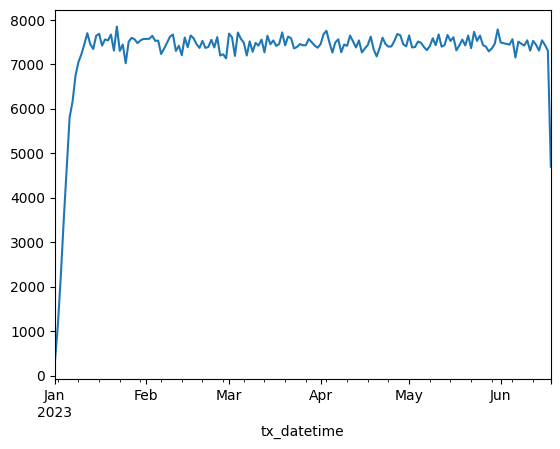

In [14]:
trx.set_index("tx_datetime").resample("D").size().plot()

<Axes: xlabel='tx_datetime'>

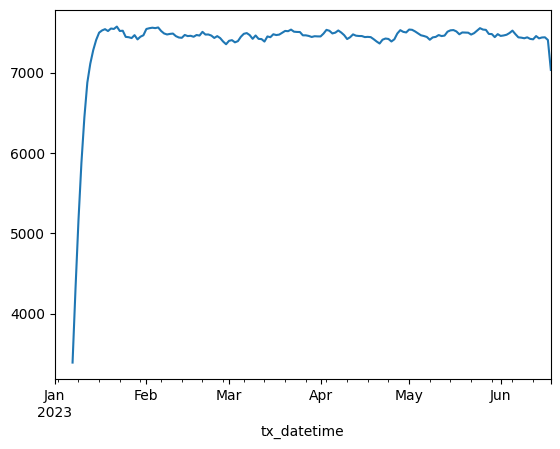

In [15]:
trx.set_index("tx_datetime").resample("D").size().rolling(7).mean().plot()

## Save datasets

In [ ]:
filenames = {
    "x_train_split.parquet.gzip": X_train,
    "x_val_split.parquet.gzip": X_val,
    "x_test_split.parquet.gzip": X_test,
}

for fn, df in filenames.items():
    df.to_parquet(os.path.join(INTERIM_DATA, fn), compression="gzip")